In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from scipy.integrate import cumtrapz, simps
import scipy.interpolate as spinterp

In [2]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')      #reading the fits file of subset of gaia astrometric data

In [3]:
stars = pd.DataFrame(dr3stars[1].data)         #assigning table to the stars info

In [4]:
stars['Name'] = stars['Name'].str.strip()     #removing the white spaces

In [5]:
stars_hiprob = stars[stars.Prob > 0.8]        #stars that have Prob>0.8 belonging to their clusters

### Task 1. 

### Here we are going to extract 6 sample quntities per cluster: 1) number of the cluster n, 2)the mean parallax $\overline{\omega}$ of the stars in the cluster, 3) the standard deviation of the parallax of the stars $\sigma_{\omega}$, 4) the size of the cluster $\sigma_{\rm pos} = \sqrt{\sigma^2_{\rm RA} + \sigma^2_{\rm DE}}$, 5) the mean proper motion of the cluster stars $\overline{\delta} = \sqrt{\delta^2_{\rm RA} + \delta^2_{\rm DE}}$, 6) the standard deviation on the proper motion $\sigma_{\delta}$ which is the same as $\sigma_{\rm pos}$

In [6]:
clcounts = stars.groupby(['Name']).size().reset_index(name='count') #resetting the indices to make our lives easier

In [7]:
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='n_star')           #population of the clusters
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()     #calculating the sd of all parameters 
clusters_mean_hiprob = stars_hiprob.groupby(['Name']).mean(numeric_only=True).reset_index()  #calculating mean of all parameters

In [8]:
# here we used the method suggested by the assignment and add the our six series of extracted data 
# as columns to the high probability star clusters

clusters_hiprob['mean_Plx'] = clusters_mean_hiprob['Plx']     
clusters_hiprob['sd_Plx'] = clusters_sd_hiprob['Plx']
clusters_hiprob['sd_RAdeg'] = clusters_sd_hiprob['RAdeg']
clusters_hiprob['sd_DEdeg'] = clusters_sd_hiprob['DEdeg']
clusters_hiprob['mean_pm']= np.sqrt(clusters_mean_hiprob['pmRA']*clusters_mean_hiprob['pmRA'] + 
                                    clusters_mean_hiprob['pmDE']*clusters_mean_hiprob['pmDE'])

clusters_hiprob['sd_pos'] = np.sqrt(clusters_sd_hiprob['RAdeg']*clusters_sd_hiprob['RAdeg'] + 
                            clusters_sd_hiprob['DEdeg']*clusters_sd_hiprob['DEdeg'])

clusters_hiprob['sd_pm'] = np.sqrt(clusters_sd_hiprob['pmRA']*clusters_sd_hiprob['pmRA'] + 
                            clusters_sd_hiprob['pmDE']*clusters_sd_hiprob['pmDE'])


### we only focus on the clusters with population more that 200 stars (n>200) and $\sigma_{\rm pos} < 1^\circ$, and we plot all the astrometric quantities except for the population of the clusters in a scatter-matirx plot. 

In [9]:
my_clusters = clusters_hiprob[(clusters_hiprob['n_star']>200) & (clusters_hiprob['sd_pos']<1)]

print('the number of the remaining clusters ' ,len(my_clusters.n_star))

the number of the remaining clusters  198


In [10]:
# we stack the columns of data points of the quantities that we are interested
# this makes it easier to use the below script to plot the scatter plot of the quantities
proxy = np.column_stack((my_clusters.mean_Plx, my_clusters.sd_Plx,
                         my_clusters.sd_pos, my_clusters.mean_pm, my_clusters.sd_pm))

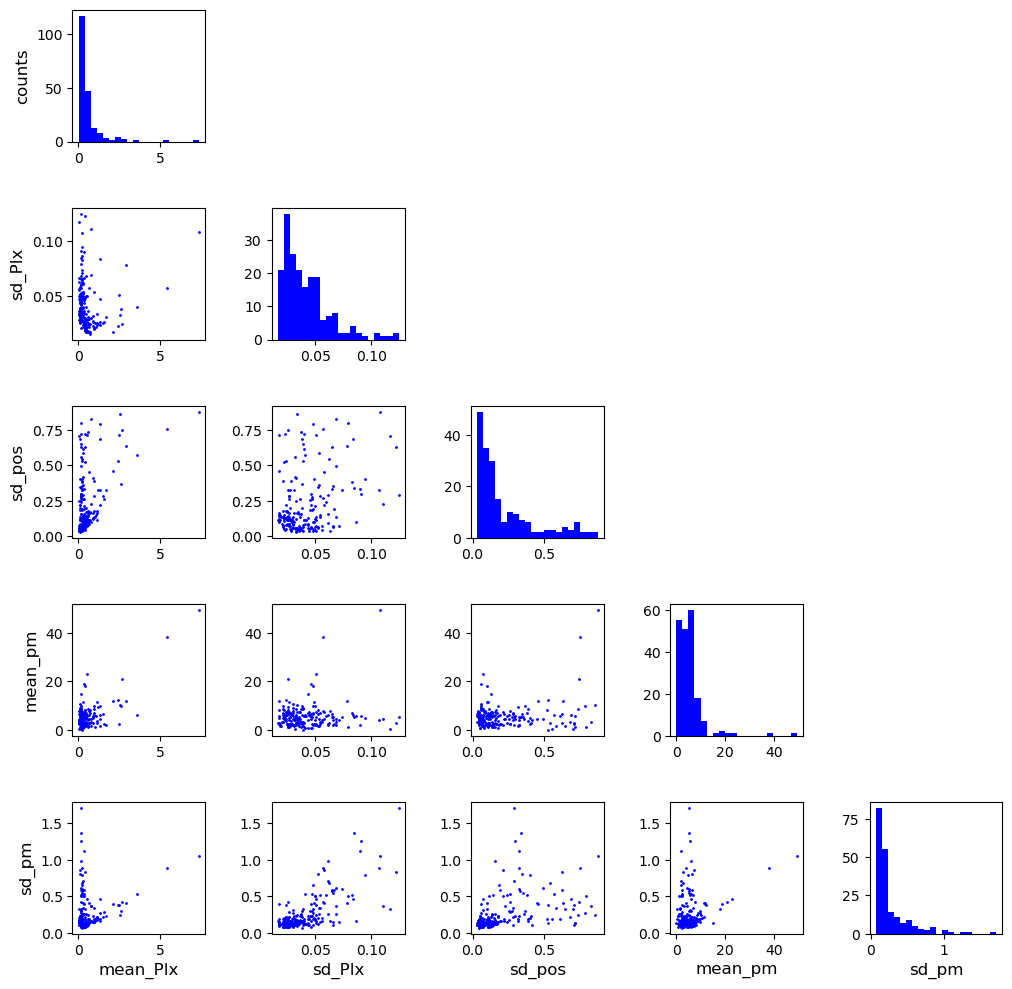

In [11]:
# Scatter-Plot

ndims=5    # number of the variables

labels = ['mean_Plx','sd_Plx','sd_pos', 'mean_pm','sd_pm']
fig, axes = plt.subplots(ndims,ndims,figsize=(12,12))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

for n in range(1):
    for i in range(ndims): ## y dimension
        for j in range(ndims): ## x dimension
            if i == j:
                axes[i,j].hist(proxy[:,i], bins=20, color='blue', zorder=10)
            elif i > j:
                axes[i,j].scatter(proxy[:,j],proxy[:,i],s=1, color='blue', zorder=10)

            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_ylabel('counts',fontsize=12)
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=12)
            if i == 4:
                axes[i,j].set_xlabel(labels[j],fontsize=12)
                
#fig.suptitle('star cluster {}'.format(new.name[0]),y=0.93)
plt.show()


### It is not easy to see if there is any correlation between parameters. All the histogram of the parameters show asymmetric distribution of the population and they are heavily skewed towards the left; the traces can also be seen in the 10 plots were data points tend to accumulate at lower values, and you see two tracks of the data points in some of the plots. 

### Task 2. 

### a.

### we can test to see if there is any correlation between these parameters. 

### One thing that we have to be careful about is the independent and identically distributed (i.i.d) data samples as was mentioned in the lecture as well, otherwise we will have a correlation measures that we cannot rely on. So, we already know that the data points of each sample are indepndant of one another, so the the 'independance' part is already satisfied, now, we check for the identically ditributed, which does not seem to be the case for most of the scatter plots. For example, we can clearly see in sd_pm versus mean_Plx scatter plot that the data points are following two different tracks as if they are from two different population which indicates that identical distribution is not satisfied. 

### Additionally, we already know that for the parameters that look to be linearly correlated it's best to use pearson's r test. Moreover, pearson responds better when the distribution of the datasets follow normal distribution. However, if  the data is more scatterd or if there are outliers in the tails of the samples, it is better to use spearman's $\rho$ correlation test.  In the following regardless of the shape of the 10 datasets, I am going to carry out the pearson and spearman test each one of them, and look at the statistics and the p-value. The statistics of the correlation can vary from -1 to 1, where -1 indicates anti-correlation between the parameters, 0 indicates no correlation, and 1 means completely correlated. The p-value, is a parameter that tells us the probability of having the statitistics for uncorrelated datasets, that is atleast as extreme as the one we calculated for our datasets. So this means that p-value help us to see how reliable our statistics are, so we should pay attention to relatively large values of the p-values.

In [12]:
import scipy.stats

In [13]:
def corr(param):
    SP   = []
    PEAR = []
    for i in range(len(param)):
        for j in range(len(param)):
        
            if i < j:
                sp   = scipy.stats.spearmanr(param[i],param[j])
                pear = scipy.stats.pearsonr(param[i],param[j])
                
                SP.append(sp)
                PEAR.append(pear)
            else:
                pass
            
    return SP, PEAR
            
                

In [14]:
param = [my_clusters.mean_Plx, my_clusters.sd_Plx,my_clusters.sd_pos, my_clusters.mean_pm, my_clusters.sd_pm]

sp, pear = corr(param)

In [15]:
n=0
for i in range(len(labels)):
    for j in range(len(labels)):
        if i < j:
            print(labels[i],'-',labels[j])
            print('spearman: ', sp[n])
            print('pearson:', pear[n])
            print()
            n+=1

mean_Plx - sd_Plx
spearman:  SignificanceResult(statistic=-0.37618565060342474, pvalue=4.712016719689901e-08)
pearson: PearsonRResult(statistic=0.047611431457136165, pvalue=0.5053546796705094)

mean_Plx - sd_pos
spearman:  SignificanceResult(statistic=0.37363637136613687, pvalue=5.8970560488021756e-08)
pearson: PearsonRResult(statistic=0.4765545158886178, pvalue=1.2759291980334748e-12)

mean_Plx - mean_pm
spearman:  SignificanceResult(statistic=0.05129245674612101, pvalue=0.4729721146639403)
pearson: PearsonRResult(statistic=0.6685482508554843, pvalue=5.222065852850302e-27)

mean_Plx - sd_pm
spearman:  SignificanceResult(statistic=0.025229207103043286, pvalue=0.7242272544725276)
pearson: PearsonRResult(statistic=0.22846785573833425, pvalue=0.0012062465572070774)

sd_Plx - sd_pos
spearman:  SignificanceResult(statistic=0.2087742202784419, pvalue=0.003160198292861663)
pearson: PearsonRResult(statistic=0.34130484497864677, pvalue=8.62171156339053e-07)

sd_Plx - mean_pm
spearman:  Signific

### b.

### We know that our datasets are all heavily skewed. Pearson test which measures the linearity of the correlation can be affected by these skewness, since there might exist outliers in such accumulations. In order to make the test more accurate, we can use the log-transformation as suggested by the assignment. The log-transformation is a handy way to disolve the accumulations of the data sets in an interval by spreading them to their equivalant logarithmic distances, hence when you apply the logarithm, the skewenes disapear, and the datasets get closer to normal distrbution where the pearson test responds better.

In [16]:
logmean_Plx = np.log(my_clusters.mean_Plx)
logsd_Plx = np.log(my_clusters.sd_Plx)
logsd_pos = np.log(my_clusters.sd_pos)
logmean_pm = np.log(my_clusters.mean_pm)
logsd_pm = np.log(my_clusters.sd_pm)

logparam = [logmean_Plx, logsd_Plx,logsd_pos, logmean_pm, logsd_pm]

sp_log, pear_log = corr(logparam)

In [17]:
n=0
for i in range(len(labels)):
    for j in range(len(labels)):
        if i < j:
            print(labels[i],'-',labels[j])
            print('spearman: ', sp_log[n])
            print('pearson:', pear_log[n])
            print()
            n+=1

mean_Plx - sd_Plx
spearman:  SignificanceResult(statistic=-0.37618565060342474, pvalue=4.712016719689901e-08)
pearson: PearsonRResult(statistic=-0.2520360213142649, pvalue=0.00034096501088115507)

mean_Plx - sd_pos
spearman:  SignificanceResult(statistic=0.37363637136613687, pvalue=5.8970560488021756e-08)
pearson: PearsonRResult(statistic=0.4285221251455444, pvalue=3.01224224533661e-10)

mean_Plx - mean_pm
spearman:  SignificanceResult(statistic=0.05129245674612101, pvalue=0.4729721146639403)
pearson: PearsonRResult(statistic=0.1963906921753753, pvalue=0.005553836196842537)

mean_Plx - sd_pm
spearman:  SignificanceResult(statistic=0.025229207103043286, pvalue=0.7242272544725276)
pearson: PearsonRResult(statistic=0.1114452122714161, pvalue=0.11802497793404318)

sd_Plx - sd_pos
spearman:  SignificanceResult(statistic=0.2087742202784419, pvalue=0.003160198292861663)
pearson: PearsonRResult(statistic=0.26451455136998103, pvalue=0.00016603000115890992)

sd_Plx - mean_pm
spearman:  Significa

### By comparing the post-transformation correlation measures to the previous one we can see that the pearson r measures of the correlation between datasets have changed while the spearman results have remained completely unchanged. This is ofcourse not surprising, because we already know that the pearson is best used for the case of linear correlation measures, and logarithm transformation affects this aspects of the datasets. On the other hand, the spearman is used for datasets where there seems to be a monotonic relationships between the variables, and it works fine event if there's skewness or outliers in data, which is not the case for pearson. That is why the results of pearson has responded to logarithm transformation while the spearman measures have remained invariant. 

In [18]:
# this makes it easier to use the below script to plot the scatter plot of the quantities
proxy_log = np.column_stack((logmean_Plx, logsd_Plx,logsd_pos, logmean_pm, logsd_pm))

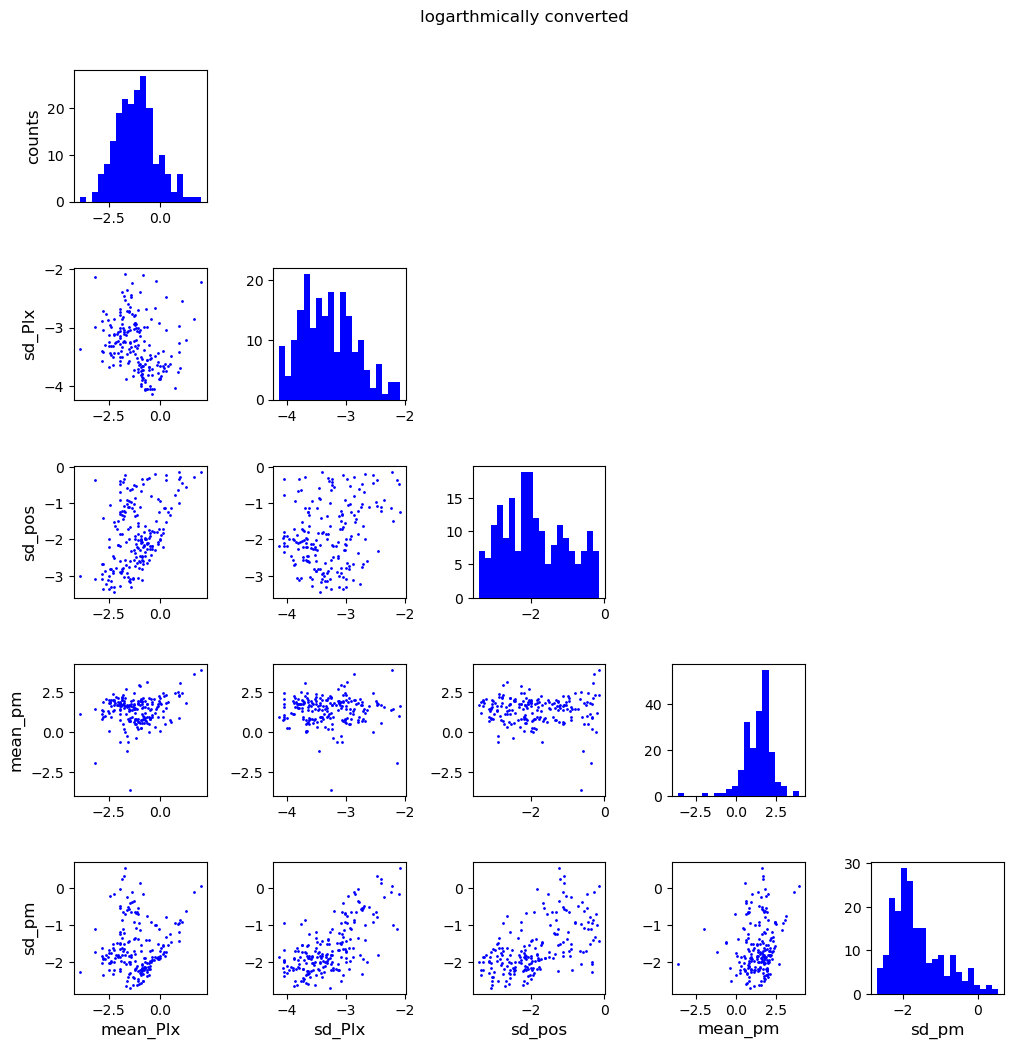

In [19]:
# Scatter-Plot

ndims=5    # number of the variables

labels = ['mean_Plx','sd_Plx','sd_pos', 'mean_pm','sd_pm']
fig, axes = plt.subplots(ndims,ndims,figsize=(12,12))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

for n in range(1):
    for i in range(ndims): ## y dimension
        for j in range(ndims): ## x dimension
            if i == j:
                axes[i,j].hist(proxy_log[:,i], bins=20, color='blue', zorder=10)
            elif i > j:
                axes[i,j].scatter(proxy_log[:,j],proxy_log[:,i],s=1, color='blue', zorder=10)

            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_ylabel('counts',fontsize=12)
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=12)
            if i == 4:
                axes[i,j].set_xlabel(labels[j],fontsize=12)
                
fig.suptitle('logarthmically converted',y=0.93)
plt.show()


### Task 3.  First, we pick up a random sample from the clusters we had already selected, and extract the parallaxes of its stras

In [20]:
random_cluster = my_clusters.sample(n=1)
print(random_cluster)

          Name  n_star  mean_Plx   sd_Plx  sd_RAdeg  sd_DEdeg   mean_pm  \
2983  HSC_2363     244  0.141722  0.04195  0.101291  0.050809  5.508796   

       sd_pos     sd_pm  
2983  0.11332  0.112958  


In [21]:
random_cluster_name = 'NGC_2360'

In [22]:
Plx_rc = stars_hiprob[(stars_hiprob['Name']==random_cluster_name)]['Plx']
Plx_rc = stars_hiprob[(stars_hiprob['Name']==random_cluster_name)]['Plx'] + 0.029*np.ones(len(Plx_rc))
Plx_sd = stars_hiprob[(stars_hiprob['Name']==random_cluster_name)]['e_Plx']

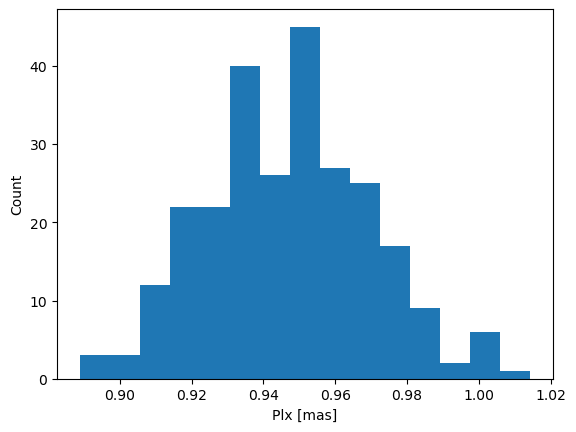

In [23]:
fig = figure()

frame = fig.add_subplot(1,1,1)

frame.hist(Plx_rc,bins=15)
frame.set_xlabel('Plx [mas]')
frame.set_ylabel('Count')

show()

### Next, we are going to calculate the posterior pdf of the distance d. To that we need to use the Bayes theorem, and the first step is to form our formulation:

$\large{\rm P(d|Plx) = \frac{P(Plx|d)P(d)}{P(Plx)}}$

### where P(d|Plx) is the posterior we are looking forward to caluclate, P(Plx|d)P(d) is the likelihood of the Plx data given the pdf of the distance, and P(Plx) is our evidence, where it counts for all the possible scenarios of the pdf of the Plx. The P(Plx) as we know can we calculated by marginalisation such that:

$\rm P(Plx) = \int_0^{\infty} \rm {P(Plx|d)P(d)} dd$

### we produce the posterior for two different priors: the first prior is a uniform prior where P(d) is constant, and will cancel out with the one in denominator. So the final posterior we need to calculate would look like:

$\large{\rm P(d|Plx) = \frac{P(Plx|d)}{\int_0^{\infty} \rm {P(Plx|d)} dd}}$

### as suggested by the assignment, we can assume that the Plx is normally distrbuted (we can actually see it in the above histogram), so we can write the $ P(Plx|d) = \frac{1}{\sigma \sqrt{2 \pi}} exp(-\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2})$

### where then we can write the $x =Plx$ (it is given), and $\mu = \overline{Plx} = \frac{1}{\overline{d}}$, we create an array of distance in a reasonable range, considering the values of the parallax. We want to know the true mean of the Plx, so we try for various distances and get a pdf of Plx, given each distance.  We know the minimum and maximum value of the parallax, therefore, we expect the distance to the cluster must be a value that falls within a corresponding distances. 


In [24]:
print(f'the most probabale distance must be a value between {1/Plx_rc.max():.2f} kpc and {1/Plx_rc.min():.2f} kpc')

the most probabale distance must be a value between 0.99 kpc and 1.13 kpc


### in the below code we use the logpdf, instead of the norm because we want to avoid a blow-up in our computation. So what we do is that we first calculate the logarithm of the pdfs, and since we want the total likelihood, we sum them up instead of multiplying them. Then we take the exponentioal, which will be equivalant to the product of the pdfs. we try then to come up with some sort of a way to smooth the pdf values before we take their exponential, the reason is that the pdf values are very large, and if take the exponential the computation will blow up, so we remove the maximum value of the pdf array from each component, so that the the maximum of the likelihood, when you take the exponential, will be $e^0=1$. 

### Now, that we have the likelihood, we can calculate the evidence by marginalising the likelihood, where we integrate over distance, as shown in our Bayes formalism.

### after we successfully created the posterior for the case of unifrom prior of the distance. Now, we want to mark the $1-\sigma$ confidence interval on the distance. So we know that $1\sigma$ from the mean is equivalant of the probability of 0.5-0.34, and 0.5+0.34 which is interval $p \in [0.16, 0.84]$. So in order to find the distance equivalant to this range of probability on the posterior, we first find the cdf of the posterior, interpolate the function over the range of our distances, then find the equivalant distances of our $1\sigma$ confidence interval.

In [25]:
def variables(cluster_name):
    '''this funvtion takes the name of a cluster and returns 
       the corrected parallaxes and the standard deviations on them'''
    
    Plx_rc = stars_hiprob[(stars_hiprob['Name']==cluster_name)]['Plx']
    Plx_rc = stars_hiprob[(stars_hiprob['Name']==cluster_name)]['Plx'] + 0.029*np.ones(len(Plx_rc))
    Plx_sd = stars_hiprob[(stars_hiprob['Name']==cluster_name)]['e_Plx']
    
    return Plx_rc, Plx_sd
    

def grand(Plx, Plx_sd, prior, Nd, RAN):
    '''This function takes the parllaxes (Plx), their standar deviations (Plx_sd), the prior (1 means uniform),
        number of the distance trials, and the range of the distance in Kpc
        and calculates the posterior of the distance given the prior,
        and the confidence interval of 1-sigma (int68), and the most probable distance (d_mp)'''
    
    N= Nd                      # number of distance values we are going to plug into the mean of likelihood
    x = Plx                    # the variable of the likelihood would be the Plx datapoints

    dsyn = np.linspace(RAN[0],RAN[1],N)  # the array of the distance values
    mu = 1/dsyn                 # converting the array to the parallax to plug into the likelihood
    sigma = Plx_sd             # standard deviation of the parallaxes are set by their errors suggested by the assginment

    #constructing the likelihood pdf
    like_pdf = scipy.stats.norm.logpdf(x=x.values.reshape(1,len(x.values)),loc=mu.reshape(N,1),scale=sigma.values.reshape(1,len(x.values)))

    likelihood_proxy= np.sum(like_pdf,axis=1)
    likelihood = np.exp(likelihood_proxy - likelihood_proxy.max())
    
    evidence   = simps(likelihood*prior,dsyn,axis=0) 
    posterior = likelihood*prior/evidence
    
    posterior_cdf = cumtrapz(posterior,dsyn,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf,dsyn)
    d_mp = dsyn[np.argmax(posterior)]
    
    int68 = posterior_ppf([0.16,0.84])   ### 0.5(+-)0.68 ~ 1sigma
    
    return posterior, int68, d_mp

### we construct the new prior following the prior given in the assignment:

$\large{p(d) \propto d^2 e^{-d / L} \rightarrow p(d) =C. d^2 e^{-d / L}}$

### where L=1, d is the distance

In [26]:
Nd= 50000

dsyn =np.linspace(0.05,15,Nd)

In [27]:
def PriorPL(Nd,d):
    '''non-uniform more accurate prior'''
    L=1
    c=1
    prior_pl = c*d*d*np.exp(-d/L)
    
    return prior_pl

prior_pl = PriorPL(Nd,dsyn)

In [28]:
posterior_uniform, int68_uniform, d_mp_uniform = grand(variables('NGC_2360')[0]
                                                       ,variables('NGC_2360')[1],1,Nd,(0.05,15))

posterior_pl,int68_pl, d_mp_pl = grand(variables('NGC_2360')[0],
                                       variables('NGC_2360')[1], prior_pl,Nd,(0.05,15))


In [29]:
print(dsyn[np.argmax(posterior_uniform)])
print(d_mp_uniform)

1.0513710274205483
1.0513710274205483


### In the below part, I will create a simple normal distribution of the distance with the mean derived my the $\mu = \frac{1}{\overline{Plx}}$. We will see that this value is very different than the ones derived from the Bayesian method.

In [30]:
sigma_plx_mean = Plx_rc.values.std()/np.sqrt(len(Plx_rc.values))         #the standard error on the mean parallax
mu = 1/(Plx_rc.values.mean())                                            #distance calculated by the mean parallax
sigma_d = (mu*mu*sigma_plx_mean)                                        #standard deviation on the distance
like_pdf_simple = scipy.stats.norm.pdf(x=dsyn,loc=mu,scale=sigma_d)

In [31]:
print(d_mp_pl)

1.0513710274205483


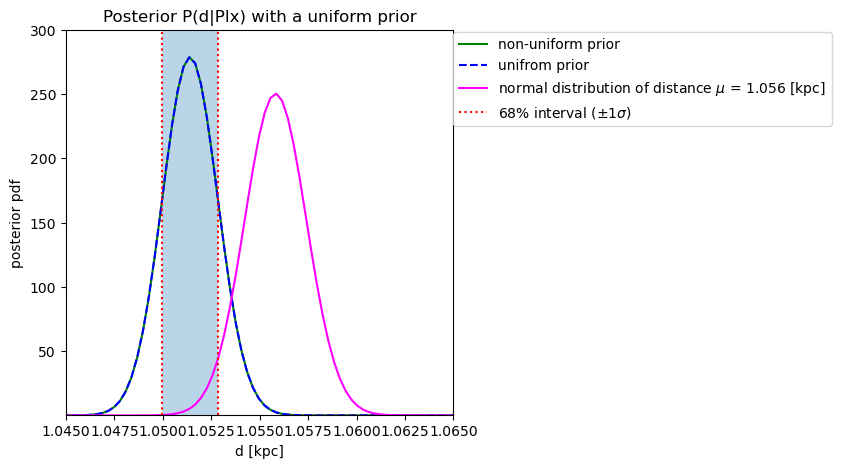

In [32]:
fig = figure(figsize = (5,5))
frame = fig.add_subplot(1,1,1)

frame.plot(dsyn,posterior_pl , '-g',label = 'non-uniform prior')
frame.plot(dsyn,posterior_uniform , '--b',label='unifrom prior')
frame.plot(dsyn,like_pdf_simple , ls='-',color = 'magenta',
           label = fr'normal distribution of distance $\mu$ = {mu:.3f} [kpc] ')

frame.vlines(int68_pl,ymin=0,ymax=300,color='red',linestyle='dotted', label = r'68% interval ($\pm 1\sigma$)')
frame.fill_between(int68_uniform, 0, 300, alpha=0.3)
frame.set_xlim(1.045,1.065)
frame.set_ylim(0.5,300)
frame.legend(loc=(1,0.75))
frame.set_xlabel('d [kpc]')
frame.set_ylabel('posterior pdf')
frame.set_title('Posterior P(d|Plx) with a uniform prior')
show()

In [33]:
print(dsyn[np.argmax(posterior_uniform)])

1.0513710274205483


In [34]:
print(f'the most probable distance to the cluster NGC_2360 using uniform prior is d = {d_mp_uniform:.9f} kpc')
print(f'the most probable distance to the cluster NGC_2360 using non-uniform prior is d = {d_mp_pl:.9f} kpc')

the most probable distance to the cluster NGC_2360 using uniform prior is d = 1.051371027 kpc
the most probable distance to the cluster NGC_2360 using non-uniform prior is d = 1.051371027 kpc


### We can see in the above plot that the most probable distances calculated using different priors do not produce different distances to 9 decimals. 

### Task 4. 

### In this part, I am going to find the most probable distance for all the clusters, and correct four paramters as I will mention later. For the calculation of the distances, I am at the mercy of my computers memory capacity which is very low (5 GB), I hav to compromise between the distance range and population of the synthetic distances in order to find the more accurate most probable distance, and the same not missing any cluster. This turned out to be not possible, at some point, I cannot cover all the clusters, and since I do not have enough time to change my formalism at this stage of the assignment, I will carry on by just ignoring the problematic clusters. 

In [43]:
d_grand = np.zeros(len(my_clusters.Name))
ND=10000
RAN = (0.002,20)
dsynn =np.linspace(RAN[0],RAN[1],ND)
problem = []
pindex = []
for i,name in enumerate(my_clusters.Name):
    try:
        plx = variables(name)[0]
        sigma = variables(name)[1]
        d_grand[i] = grand(plx,sigma,PriorPL(ND,dsynn),ND,RAN)[2]    
    except:
        d_grand[i] = float('Nan')
        problem.append(name)
        pindex.append(pindex)
        print('problematic clusters which I will ignore for the feature calculation,', name)

problematic clusters which I will ignore for the feature calculation, NGC_2287
problematic clusters which I will ignore for the feature calculation, NGC_2632
problematic clusters which I will ignore for the feature calculation, NGC_3532
problematic clusters which I will ignore for the feature calculation, NGC_5822
problematic clusters which I will ignore for the feature calculation, NGC_6124
problematic clusters which I will ignore for the feature calculation, NGC_6475
problematic clusters which I will ignore for the feature calculation, OC_0470
problematic clusters which I will ignore for the feature calculation, Pozzo_1


### In the last part we are going to do corrections on four parameters: $\sigma_\omega, \sigma_{\mathrm{pos}}, \bar{\delta}, \sigma_\delta$

### So I already have these parameters, and the distances to their clusters. So I find out how each one of the change with the distance, I can easily calculate them at the new distance d = 1kpc. 

### $\sigma_{\omega_1} = \sigma_{d_1} |-\frac{1}{d_1^2}|$ and  $\sigma_{\omega_2} = \sigma_{d_2} |-\frac{1}{d_2^2}|$

$\large{\Rightarrow \sigma_{\omega_2} = \sigma_{\omega_1} \frac{\sigma_{d_2}}{\sigma_{d_1}} \frac{d_1^2}{d_2^2}}$

### now, we will assume that the standrad deviation on the distance remain the same, otherwise  we have to deal with a situation that the two variables become co-dependant, we would not be able to deal with the problem. So we simplify

$\large{\Rightarrow \sigma_{\omega_2} = \sigma_{\omega_1} \frac{d_1^2}{d_2^2}}$

### Now, we deal with the second parameter which is the size of the cluster which we then use the relation of $\sigma_{pos} \propto \frac{1}{d}$

$\large{\Rightarrow \sigma_{pos_2} =\sigma_{pos_1}\frac{d_1}{d_2}}$

### same formalism is true for the mean proper motion $\overline{\delta} \propto \frac{1}{d}$ and its standard deviation, both parameters scale linearly with inverted distance.

$\large{\overline{\delta_2} =\overline{\delta_1}\frac{d_1}{d_2}}$

### and 

$\large{\sigma_{\overline{\delta_2}} =\sigma_{\overline{\delta_1}}\frac{d_1}{d_2}}$

### now that we know how we can calculate the new parameters, we can write the script:

In [36]:
def correction(sd_plx,sd_pos,mean_pm,sd_pm,d1):
    
    d2 = 1 #kpc
    
    sd_plx_corr    = sd_plx   * (d1*d1)/(d2*d2) 
    sd_pos_corr    = sd_pos   * (d1/d2)
    mean_pm_corr   = mean_pm  * (d1/d2)
    sd_pm_corr     = sd_pm    * (d1/d2)
    
    return sd_plx_corr, sd_pos_corr, mean_pm_corr,sd_pm_corr

In [37]:
new = pd.DataFrame()
sd_Plx_corr = []
sd_pos_corr   = []
mean_pm_corr  = []
sd_pm_corr    = []

for i,name in enumerate(my_clusters.Name):
    if not np.isnan(d_grand[i]):
        sd_plx  = my_clusters[my_clusters.Name==name].sd_Plx
        sd_pos  = my_clusters[my_clusters.Name==name].sd_pos
        mean_pm = my_clusters[my_clusters.Name==name].mean_pm
        sd_pm   = my_clusters[my_clusters.Name==name].sd_pm
        
        corrected = correction(sd_plx,sd_pos,mean_pm,sd_pm,d_grand[i])
        
        
        sd_Plx_corr.append(np.log(corrected[0]).values[0])
        sd_pos_corr.append(np.log(corrected[1]).values[0])
        mean_pm_corr.append(np.log(corrected[2]).values[0])
        sd_pm_corr.append(np.log(corrected[3]).values[0])
    else:
        print(f'it is not possible to calculate for the cluster {name}')

it is not possible to calculate for the cluster Collinder_69
it is not possible to calculate for the cluster IC_4725
it is not possible to calculate for the cluster Melotte_22
it is not possible to calculate for the cluster NGC_1647
it is not possible to calculate for the cluster NGC_2287
it is not possible to calculate for the cluster NGC_2548
it is not possible to calculate for the cluster NGC_2632
it is not possible to calculate for the cluster NGC_6124
it is not possible to calculate for the cluster Stock_2


In [38]:
proxy_log_corr = [sd_Plx_corr, sd_pos_corr, mean_pm_corr, sd_pm_corr]

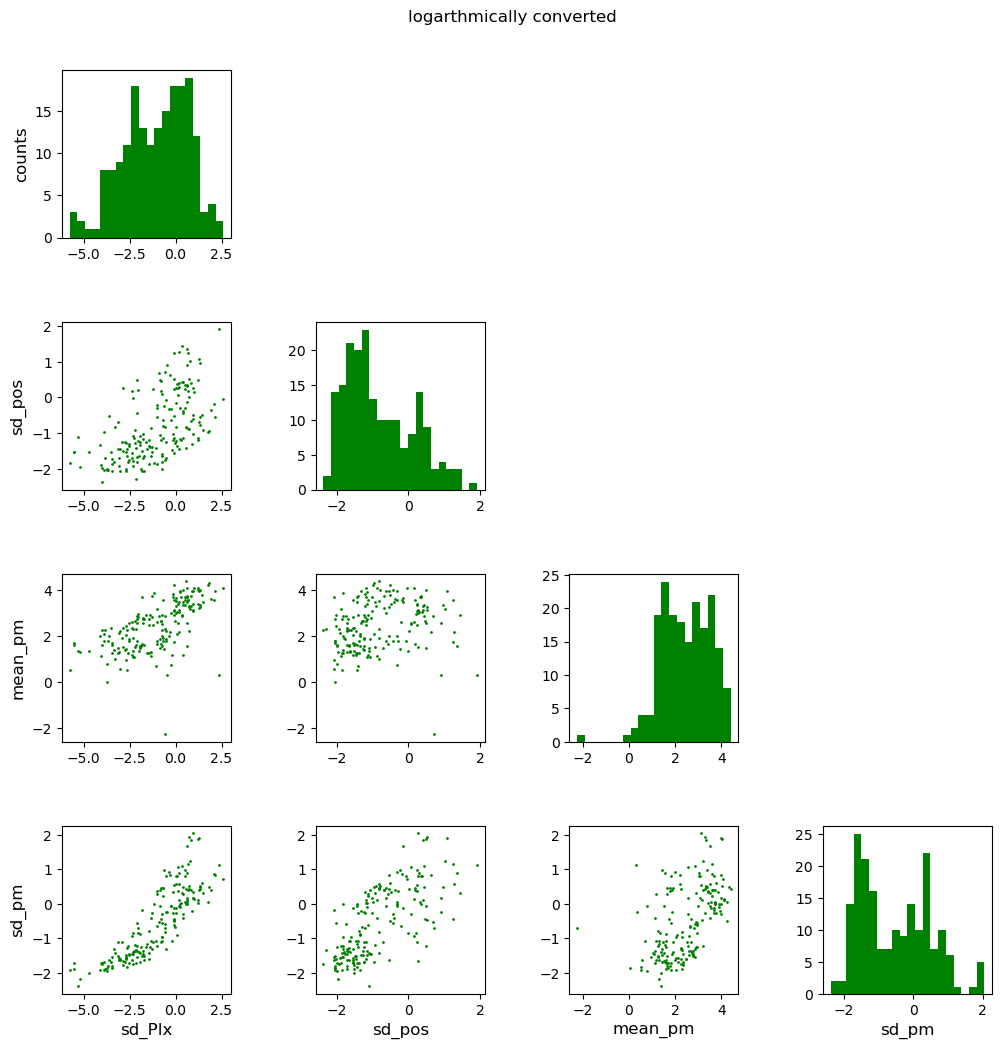

In [39]:
# Scatter-Plot

ndims=4    # number of the variables

labels = ['sd_Plx','sd_pos', 'mean_pm','sd_pm']
fig, axes = plt.subplots(ndims,ndims,figsize=(12,12))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

for n in range(1):
    for i in range(ndims): ## y dimension
        for j in range(ndims): ## x dimension
            if i == j:
                axes[i,j].hist(proxy_log_corr[i], bins=20, color='green', zorder=10)
            elif i > j:
                axes[i,j].scatter(proxy_log_corr[j],proxy_log_corr[i],s=1, color='green', zorder=10)

            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_ylabel('counts',fontsize=12)
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=12)
            if i == 3:
                axes[i,j].set_xlabel(labels[j],fontsize=12)
                
fig.suptitle('logarthmically converted',y=0.93)
plt.show()


In [40]:
sp_log_corr, pear_log_corr = corr(proxy_log_corr)

In [41]:
n=0
for i in range(len(labels)):
    for j in range(len(labels)):
        if i < j:
            print(labels[i],'-',labels[j])
            print('spearman: ', sp_log_corr[n])
            print('pearson:', pear_log_corr[n])
            print()
            n+=1

sd_Plx - sd_pos
spearman:  SignificanceResult(statistic=0.6317033719049396, pvalue=1.918548354650774e-22)
pearson: PearsonRResult(statistic=0.5803477208807857, pvalue=2.093563268197783e-18)

sd_Plx - mean_pm
spearman:  SignificanceResult(statistic=0.6848237615314884, pvalue=1.6783730029016226e-27)
pearson: PearsonRResult(statistic=0.6165218594439668, pvalue=3.580506848921383e-21)

sd_Plx - sd_pm
spearman:  SignificanceResult(statistic=0.880483122700368, pvalue=1.5991172452065305e-62)
pearson: PearsonRResult(statistic=0.846053190905816, pvalue=5.625053895016525e-53)

sd_pos - mean_pm
spearman:  SignificanceResult(statistic=0.3276453545210544, pvalue=4.181059548557103e-06)
pearson: PearsonRResult(statistic=0.22162328159706357, pvalue=0.002178096929834112)

sd_pos - sd_pm
spearman:  SignificanceResult(statistic=0.7258429762349136, pvalue=3.2742914878633854e-32)
pearson: PearsonRResult(statistic=0.6998399081331695, pvalue=3.923997018675388e-29)

mean_pm - sd_pm
spearman:  SignificanceResul

### the above result show an improvement in correlation for all the parameters after we corrected the parameters, the most prominent one is the sd_pos - sd_pm, which has turned a very low p-value, hinting towards the idea that it is less likely that the correlation is by accident. However, I am still able to discern two tracks on this plot, meaning that we have to take this result with grain of salts since the 'identically distributed' part of the 'i.d.d' is shaky. The same pattern could be seen in sd_pos - sd_Plx, but overall the correction of the parameters have significantly improve the correaltion among them.   